In [36]:
import json, os, pathlib as p
import nibabel as nib
import numpy as np
from monai.networks.nets import UNet
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pickle
from model import UnetGenerator3D
from dataset import TrainDataset
from preprocessing import create_LR_img, scale_to_reference_img, pad_to_shape, extract_3D_patches, reconstruct_from_patches



In [58]:

#Find data
DATA_DIR = p.Path.home()/"data"/"bobsrepository"
t1_files = sorted(DATA_DIR.rglob("*T1w.nii.gz"))
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
files = list(zip(t1_files, t2_files))
print(files)
#Use 70% of data for training, 20% for validation, 10% for testing
train_t1_files = t1_files[:50]
train_t2_files = t2_files[:50]
val_t1_files = t1_files[50:64]
val_t2_files = t2_files[50:64]
test_t1_files = t1_files[64:]
test_t2_files = t2_files[64:]

#Load reference image (T1w)
ref_img = nib.load(t1_files[0])

#Use 70% of data for training
print(round(len(t1_files)*0.7), len(train_t1_files), len(val_t2_files))

[(PosixPath('/Users/al1612le/data/bobsrepository/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz'), PosixPath('/Users/al1612le/data/bobsrepository/sub-116056/ses-3mo/anat/sub-116056_ses-3mo_space-INFANTMNIacpc_T2w.nii.gz')), (PosixPath('/Users/al1612le/data/bobsrepository/sub-116845/ses-3mo/anat/sub-116845_ses-3mo_space-INFANTMNIacpc_T1w.nii.gz'), PosixPath('/Users/al1612le/data/bobsrepository/sub-116845/ses-3mo/anat/sub-116845_ses-3mo_space-INFANTMNIacpc_T2w.nii.gz')), (PosixPath('/Users/al1612le/data/bobsrepository/sub-116845/ses-6mo/anat/sub-116845_ses-6mo_space-INFANTMNIacpc_T1w.nii.gz'), PosixPath('/Users/al1612le/data/bobsrepository/sub-116845/ses-6mo/anat/sub-116845_ses-6mo_space-INFANTMNIacpc_T2w.nii.gz')), (PosixPath('/Users/al1612le/data/bobsrepository/sub-176427/ses-5mo/anat/sub-176427_ses-5mo_space-INFANTMNIacpc_T1w.nii.gz'), PosixPath('/Users/al1612le/data/bobsrepository/sub-176427/ses-5mo/anat/sub-176427_ses-5mo_space-INFANTMNIacpc_T2w.nii.gz')),

In [42]:
#OUTPUT: T2 HR IMAGES
output_images = []
for i in range(len(train_t2_files)):
    hr_t2 = nib.load(train_t2_files[i])
    hr_t2_data = hr_t2.get_fdata()
    hr_t2 = scale_to_reference_img(hr_t2, ref_img)
    print(f"Loaded and scaled image {i+1}/{len(train_t2_files)}")
    #zero pad to fit model input size
    hr_t2_data, new_affine = pad_to_shape(hr_t2.get_fdata(), (192, 224 , 192), hr_t2.affine)
    hr_t2 = nib.Nifti1Image(hr_t2_data, new_affine)
    
    output_images.append(hr_t2)


Loaded and scaled image 1/50
Loaded and scaled image 2/50
Loaded and scaled image 3/50
Loaded and scaled image 4/50
Loaded and scaled image 5/50
Loaded and scaled image 6/50
Loaded and scaled image 7/50
Loaded and scaled image 8/50
Loaded and scaled image 9/50
Loaded and scaled image 10/50
Loaded and scaled image 11/50
Loaded and scaled image 12/50
Loaded and scaled image 13/50
Loaded and scaled image 14/50
Loaded and scaled image 15/50
Loaded and scaled image 16/50
Loaded and scaled image 17/50
Loaded and scaled image 18/50
Loaded and scaled image 19/50
Loaded and scaled image 20/50
Loaded and scaled image 21/50
Loaded and scaled image 22/50
Loaded and scaled image 23/50
Loaded and scaled image 24/50
Loaded and scaled image 25/50
Loaded and scaled image 26/50
Loaded and scaled image 27/50
Loaded and scaled image 28/50
Loaded and scaled image 29/50
Loaded and scaled image 30/50
Loaded and scaled image 31/50
Loaded and scaled image 32/50
Loaded and scaled image 33/50
Loaded and scaled i

In [43]:
#INPUT 1: T2 LR IMAGES
input1_images = []
for i in range(len(train_t2_files)):
    lr_t2_data = create_LR_img(output_images[i].get_fdata(), scale_factor=2)
    lr_t2 = nib.Nifti1Image(lr_t2_data, output_images[i].affine)
    lr_t2 = scale_to_reference_img(lr_t2, ref_img)
    #zero pad to fit model input size
    padded_lr_t2, new_affine = pad_to_shape(lr_t2.get_fdata(), (192, 224 , 192), lr_t2.affine)
    lr_t2 = nib.Nifti1Image(padded_lr_t2, new_affine)
    input1_images.append(lr_t2)



In [44]:
#INPUT 2: T1 HR IMAGES
input2_images = []
for i in range(len(train_t1_files)):
    hr_t1 = nib.load(train_t1_files[i])
    hr_t1_data = hr_t1.get_fdata()
    hr_t1 = scale_to_reference_img(hr_t1, ref_img)
    #zero pad to fit model input size
    hr_t1_data_padded, new_affine = pad_to_shape(hr_t1_data, (192, 224 , 192), hr_t1.affine)
    hr_t1 = nib.Nifti1Image(hr_t1_data_padded, new_affine)
    input2_images.append(hr_t1)




In [45]:
#Extract 3D patches
patch_size = (96, 96, 96)
stride = (32, 32, 32)

#OUTPUT patches
output_patches = []
for i in range(len(output_images)):
    patches = extract_3D_patches(output_images[i].get_fdata(), patch_size, stride)
    print(f"Extracted patches from output image {i+1}/{len(output_images)}")
    output_patches.extend(patches)

#INPUT1 patches
input1_patches = []
for i in range(len(input1_images)):
    patches = extract_3D_patches(input1_images[i].get_fdata(), patch_size, stride)
    input1_patches.extend(patches)  

#INPUT2 patches
input2_patches = []
for i in range(len(input2_images)):
    patches = extract_3D_patches(input2_images[i].get_fdata(), patch_size, stride)
    print(f"Extracted patches from input2 image {i+1}/{len(input2_images)}")
    input2_patches.extend(patches)



Extracted patches from output image 1/50
Extracted patches from output image 2/50
Extracted patches from output image 3/50
Extracted patches from output image 4/50
Extracted patches from output image 5/50
Extracted patches from output image 6/50
Extracted patches from output image 7/50
Extracted patches from output image 8/50
Extracted patches from output image 9/50
Extracted patches from output image 10/50
Extracted patches from output image 11/50
Extracted patches from output image 12/50
Extracted patches from output image 13/50
Extracted patches from output image 14/50
Extracted patches from output image 15/50
Extracted patches from output image 16/50
Extracted patches from output image 17/50
Extracted patches from output image 18/50
Extracted patches from output image 19/50
Extracted patches from output image 20/50
Extracted patches from output image 21/50
Extracted patches from output image 22/50
Extracted patches from output image 23/50
Extracted patches from output image 24/50
E

In [102]:
#Save patches as numpy arrays

#OUTPUT patches - HR T2
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"HR-T2"/"output_patches.pkl", "wb") as f:
    pickle.dump(output_patches, f)

#INPUT1 patches - LR T2
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"LR-T2"/"input1_patches.pkl", "wb") as f:
    pickle.dump(input1_patches, f)

#INPUT2 patches - HR T1
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"HR-T1"/"input2_patches.pkl", "wb") as f:
    pickle.dump(input2_patches, f)




In [53]:
with open(p.Path.home()/"data"/"patch-dataset"/"val"/"HR-T2"/"output_patches.pkl", "rb") as f:
    output_patches = pickle.load(f)

with open(p.Path.home()/"data"/"patch-dataset"/"val"/"LR-T2"/"input1_patches.pkl", "rb") as f:
    input1_patches = pickle.load(f)

with open(p.Path.home()/"data"/"patch-dataset"/"val"/"HR-T1"/"input2_patches.pkl", "rb") as f:
    input2_patches = pickle.load(f)


In [46]:
dataset = TrainDataset(input1_patches, input2_patches, output_patches)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [47]:
net = UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=None,
)

In [25]:
#SINGLE INPUT

# 1. Loss and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# 2. Training loop
num_epochs = 5
device = torch.device("cpu") 

net.to(device)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for batch in dataloader:
        # Unpack your batch
        input1, input2, target = batch
        # Stack inputs along channel dimension
        inputs = input2.unsqueeze(1).float().to(device)  # (B, 1, 64, 64, 64)
        target = target.unsqueeze(1).float().to(device)  # (B, 1, 64, 64, 64)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 7.5007
Epoch 2/5, Loss: 6.7302
Epoch 3/5, Loss: 6.2236
Epoch 4/5, Loss: 5.0708
Epoch 5/5, Loss: 4.0412


In [48]:
#DOUBLE INPUT

# 1. Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# 2. Training loop
num_epochs = 5
device = torch.device("cpu") 

net.to(device)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for batch in dataloader:
        # Unpack your batch
        input1, input2, target = batch
        # Stack inputs along channel dimension
        inputs = torch.stack([input1, input2], dim=1).float().to(device)  # (B, 2, 64, 64, 64)
        target = target.unsqueeze(1).float().to(device)  # (B, 1, 64, 64, 64)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 101.4433
Epoch 2/5, Loss: 30.2363
Epoch 3/5, Loss: 22.5617
Epoch 4/5, Loss: 18.8105
Epoch 5/5, Loss: 16.5415


In [49]:
#test model

#OUTPUT patches
test_output_patches = []
patches = extract_3D_patches(output_images[0].get_fdata(), patch_size, stride)
test_output_patches.extend(patches)
print(len(test_output_patches))

#INPUT1 patches
test_input1_patches = []
patches = extract_3D_patches(input1_images[0].get_fdata(), patch_size, stride)
test_input1_patches.extend(patches)
print(len(test_input1_patches)) 

#INPUT2 patches
test_input2_patches = []
patches = extract_3D_patches(input2_images[0].get_fdata(), patch_size, stride)
test_input2_patches.extend(patches)
print(len(test_input2_patches)) 

80
80
80


In [54]:
test_output_patches = output_patches[:80]
test_input1_patches = input1_patches[:80]
test_input2_patches = input2_patches[:80]


In [56]:

#Try model #Double input

net.eval()
all_outputs = []
with torch.no_grad():
    for i in range(len(test_output_patches)):
        input1 = torch.tensor(test_input1_patches[i]).float()
        input2 = torch.tensor(test_input2_patches[i]).float()
        inputs = torch.stack([input1, input2], dim=0).unsqueeze(0)  # (1, 2, 64, 64, 64)
        output = net(inputs)
        all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (64, 64, 64)
#print("Reconstructed shape:", reconstructed.shape)
print("Expected shape:", (192, 224, 192))
print("Number of input patches:", len(all_outputs))
print("Shape of one patch:", all_outputs[0].shape)
# Reconstruct the image from patches
reconstructed = reconstruct_from_patches(all_outputs, (192, 224, 192), (32, 32, 32))




Expected shape: (192, 224, 192)
Number of input patches: 80
Shape of one patch: (64, 64, 64)


IndexError: list index out of range

In [28]:
#single input
net.eval()
all_outputs = []
with torch.no_grad():
    for i in range(len(test_output_patches)):
        #input1 = torch.tensor(test_input1_patches[i]).float()
        input2 = torch.tensor(test_input2_patches[i]).float()
        inputs = input2.unsqueeze(0).unsqueeze(0)  # (1, 1, 64, 64, 64)
        output = net(inputs)
        all_outputs.append(output.squeeze(0).squeeze(0).cpu().numpy())  # (64, 64, 64)

# Reconstruct the image from patches
reconstructed = reconstruct_from_patches(all_outputs, (192, 224, 192), (32, 32, 32))



<OrthoSlicer3D: (192, 224, 192)>

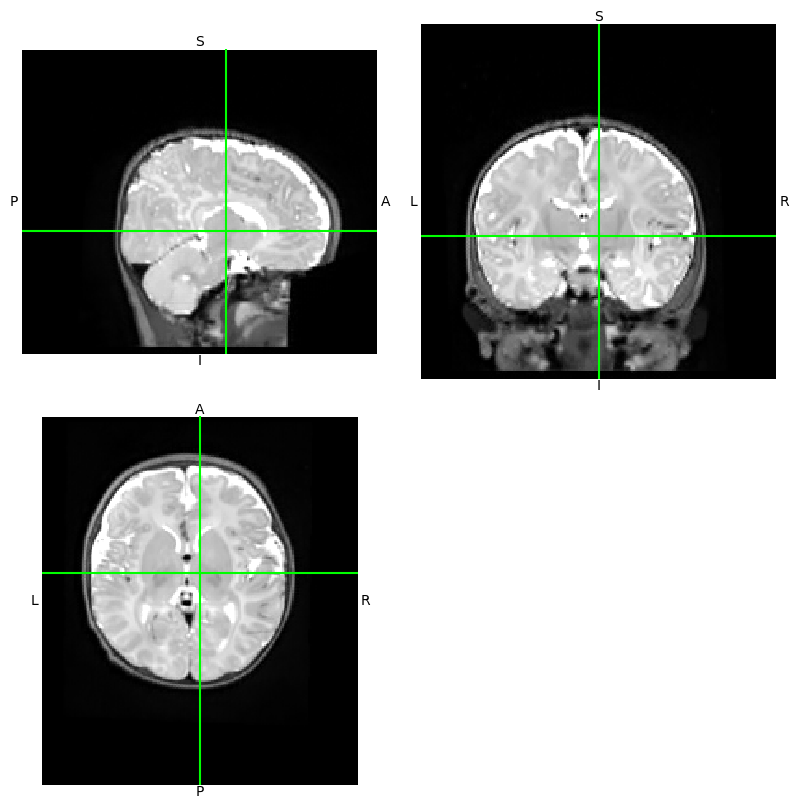

In [52]:
#convert to nifti and save
reconstructed_img = nib.Nifti1Image(reconstructed, output_images[4].affine)
reconstructed_img.orthoview()

<OrthoSlicer3D: (192, 224, 192)>

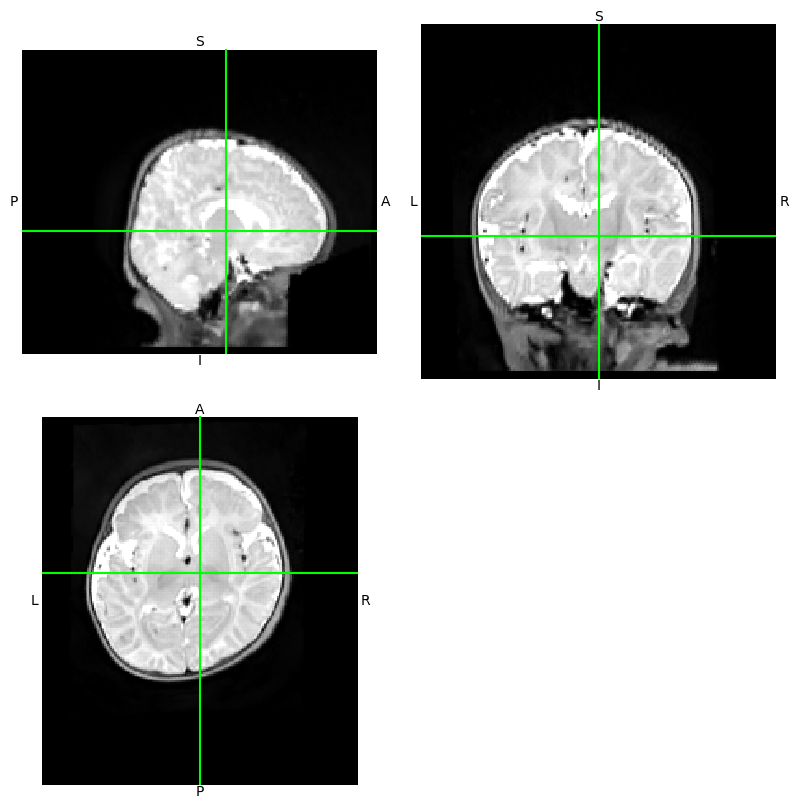

In [13]:
#convert to nifti and save
reconstructed_img = nib.Nifti1Image(reconstructed, output_images[4].affine)
reconstructed_img.orthoview()

<OrthoSlicer3D: (192, 224, 192)>

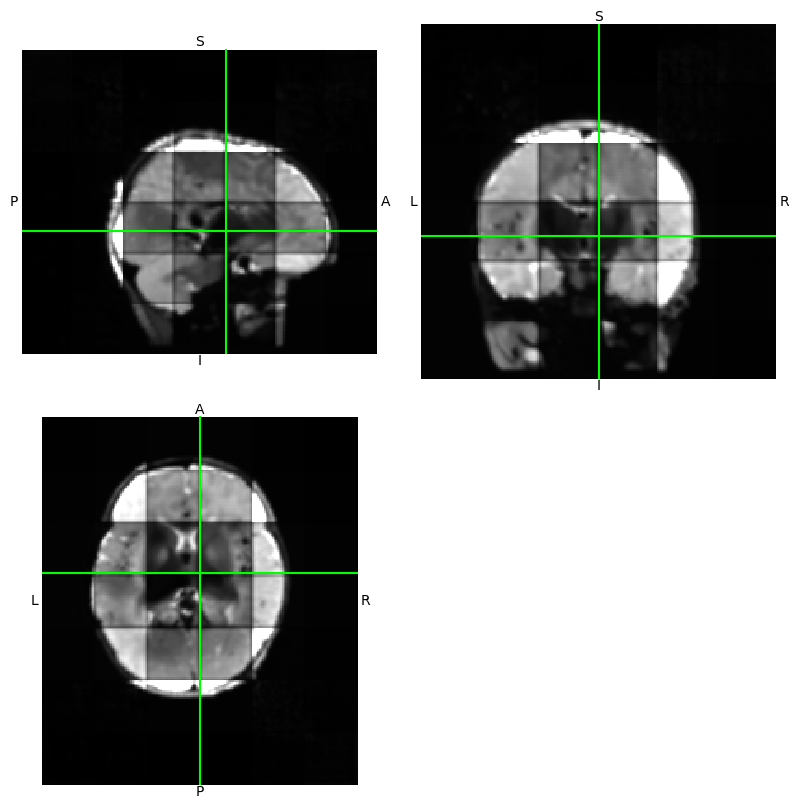

In [77]:
reconstructed_img = nib.Nifti1Image(reconstructed, output_images[4].affine)
reconstructed_img.orthoview()

<OrthoSlicer3D: (192, 224, 192)>

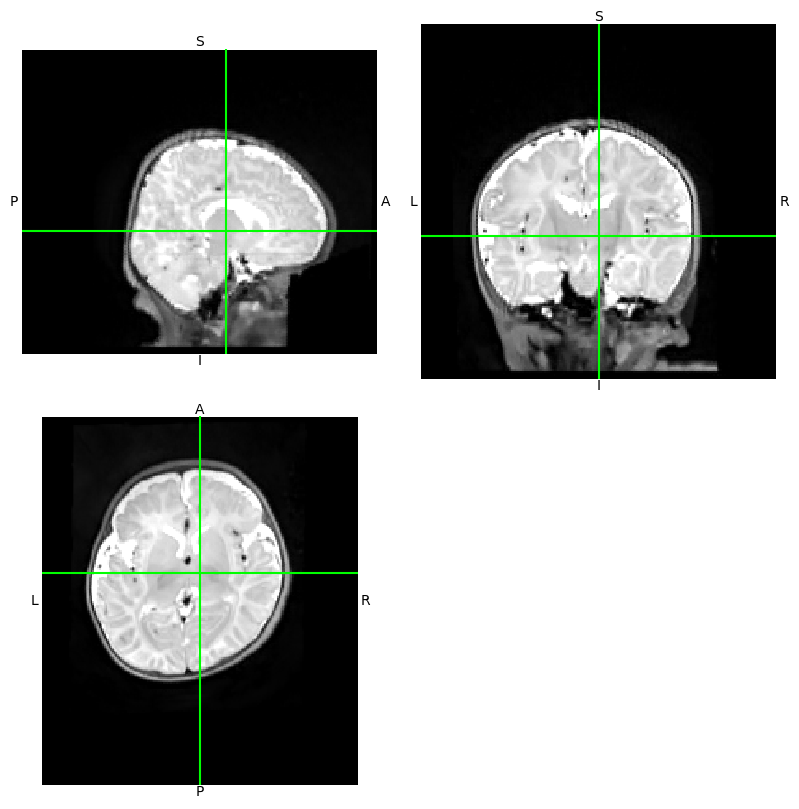

In [16]:
#convert to nifti and save
reconstructed_img = nib.Nifti1Image(reconstructed, test_img.affine)
reconstructed_img.orthoview()

<OrthoSlicer3D: (192, 224, 192)>

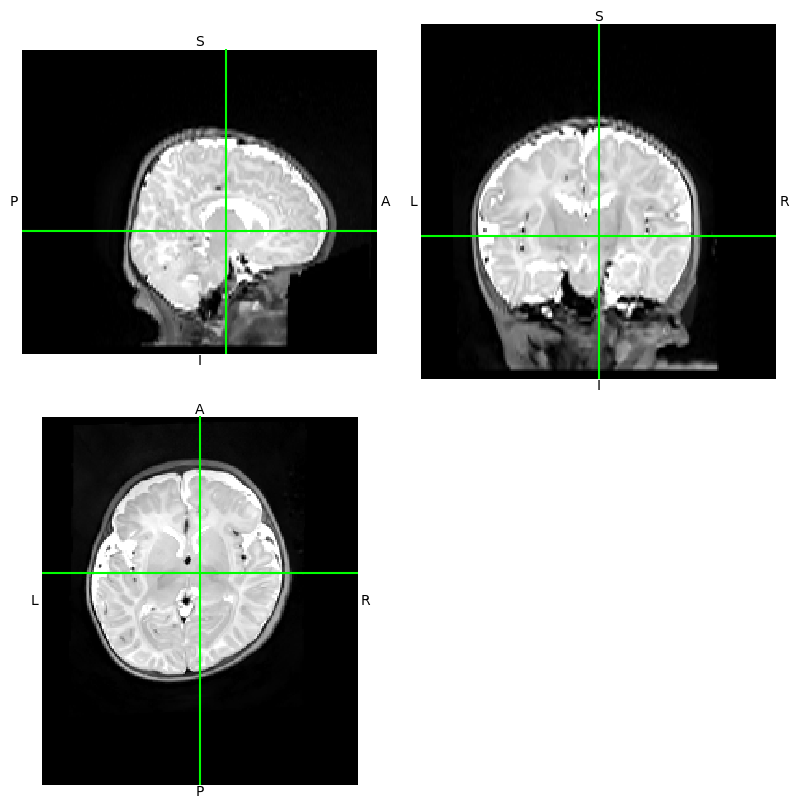

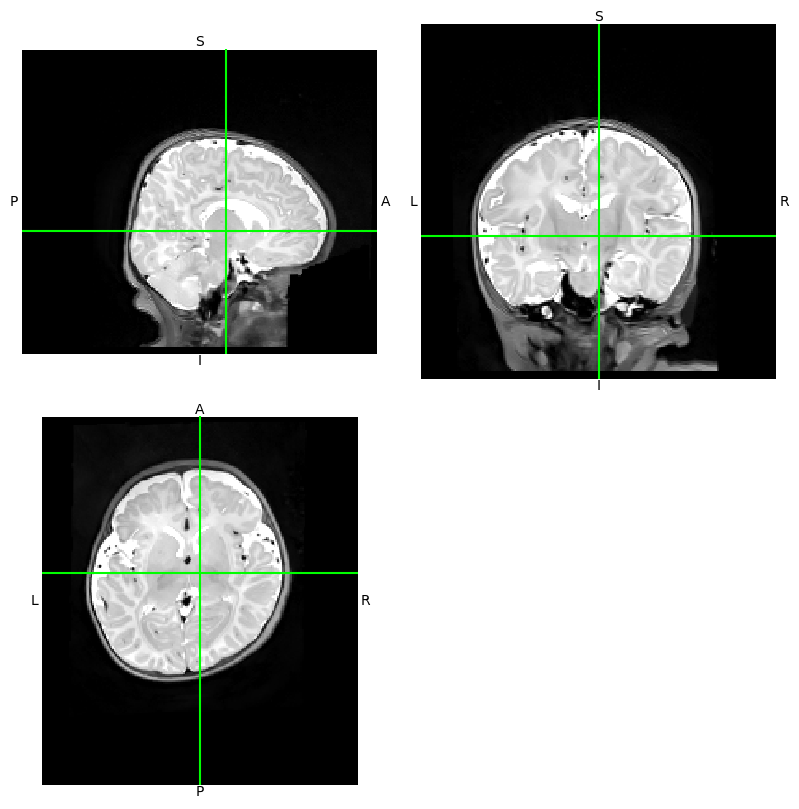

In [20]:
#input interpolated image
input1_images[0].orthoview()
output_images[0].orthoview()

In [ ]:

# Convert patches to tensors

input1_tensor = torch.stack([torch.tensor(patch) for patch in input1_patches])
input2_tensor = torch.stack([torch.tensor(patch) for patch in input2_patches])
output_tensor = torch.stack([torch.tensor(patch) for patch in output_patches])

inputs = torch.stack([input1_tensor, input2_tensor], dim=1)  # shape: (N, 2, 64, 64, 64)
output = output_tensor.unsqueeze(1)  # Now shape: (N, 1, 64, 64, 64)

print(inputs.shape, output.shape)  # Should be (N, 64, 64, 64)


In [ ]:
output = net(inputs.float())

In [ ]:

#save one patch as nifti for visualization

#patch_img = nib.Nifti1Image(patches[0], new_affine)
#patch_img.orthoview()

#reconstruct image from patches
rec = reconstruct_from_patches(patches, padded_lr_t2.shape, stride)
rec_img = nib.Nifti1Image(rec, new_affine)
#rec_img.orthoview()


In [47]:
#lr_t2_data[0:32, 0:32, 0:32]
#nib.Nifti1Image(lr_t2_data[0:64, 0:64, 0:64], lr_t2.affine).orthoview()
print(len(output_images))
len(output_patches)

4


600

(192, 224, 192)


<OrthoSlicer3D: (192, 224, 192)>

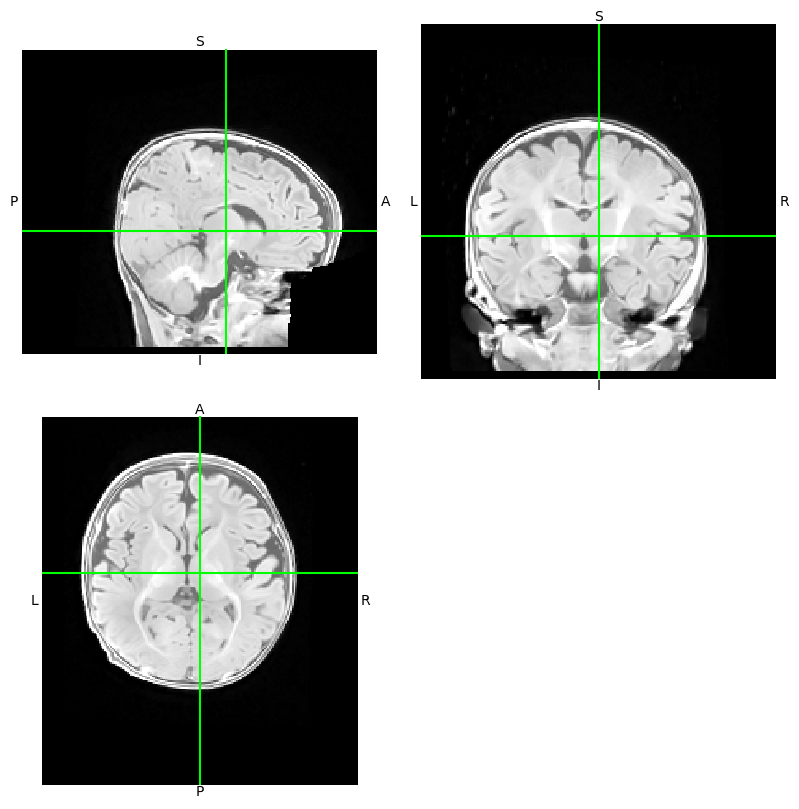

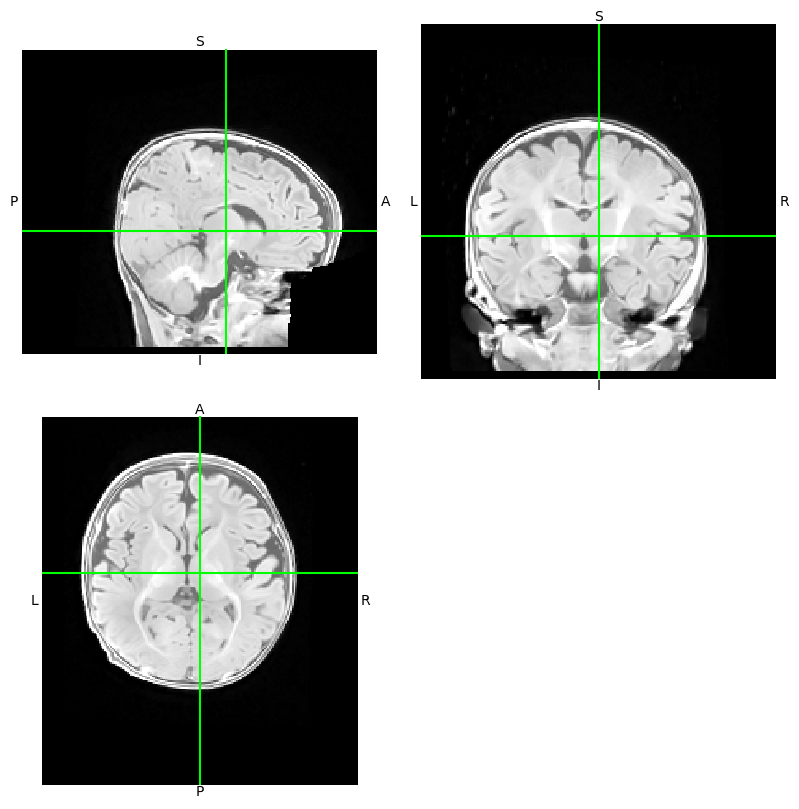

In [15]:
#test 3d patch extraction and reconstruction
test_img, test_affine = pad_to_shape(ref_img.get_fdata(), (192, 224 , 192), ref_img.affine)
print(test_img.shape)
test_img = nib.Nifti1Image(test_img, test_affine)
test_img.orthoview()

patch_size = (64, 64, 64)
stride = (32, 32, 32)
test_patches = extract_3D_patches(test_img.get_fdata(), patch_size, stride)

new_img = reconstruct_from_patches(test_patches, test_img.shape, stride)
new_img = nib.Nifti1Image(new_img, test_img.affine)
new_img.orthoview()
